# Astronomical Imaging and FITS

*Gather round, for I shall tell a tale old as time. 
Long, long ago, astronomers gazed at the heavens, and with naught but their eyes, recorded the positions of the stars they saw there. 
Then, with the telescope, long, heavy contraptions which reached for the skies like an outstretched arm, (thanks, f/20 focal lengths)
they gazed through eyepieces in freezing domes, falling, on occasion, to their deaths from cages suspended at prime foci.* 

*Next came glass -- emulsion plates -- which upon extended exposure revealed upon their ghostly frames the splotches of stars and soon, galaxies and nebulae. 
Many a grad student, of course, spent their nights twiddling thumbs over micrometer dials to keep these stars in place. Manual guiding... this story teller shudders to imagine it.
And yet, even then, with permanent record, no measure could be made that weren't 'tween the eyes of an observer, peering at the glass through magnifying eyepiece, assigning grades of brightness and, amazingly, pretty much nailing the spectral classification of stars by their absorption features*. 

*And after this painstaking work, came the earliest CCDs, fractured by detector failures, riddled with readout noise, consumed by cosmic ray hits, laid low by low quantum efficiencies.* 

*Now... we use Python.* 

## What's in an image

Astronomical images differ from standard images taken with a phone or DSLR camera primarily in that they both use older CCD technology and are typically "black and white", recording only intensity of light and not color. 

Knowledge about color instead comes from the placement of **filters** in front of the detectors which have a certain **bandpass**, allowing through light within a certain wavelength range and blocking light outside it. 

Thus, we only ever get one color at a time, unless the telescope splits incoming light by color using, for example, a **dichroic**, and then sends the two streams to two detectors with different filters simultaneously. 

This means that in some sense, single-band (i.e., one narrow-ish wavelength range) images are simple programmatically: They are 2D arrays in which each pixel (position in array) contains a single number: counts (in some units).

Usually, these units are counts in ADU (analog-to-digital units), which are roughly related to the actual counts of photons hitting the detector, via properties such as the gain of the system. 

Generally, we are not concerned with the exact units/gain/etc., because we back out the flux in photons (or energy, rather) via empirical calibrations with objects in the sky of known flux. Sometimes, we are given images that have already been flux calibrated, in which case measurements of, say, counts in an aperture are real flux units. 

# Image Handling with Astropy

Lastly, we need to know how to work with astronomical images in Python. As "simple" 2D arrays, simply opening and plotting an image is easy. But keeping track of, say, the celestial coordinates associated with a pointing on the sky, is not. 

Luckily, the open-source `astropy` library has many tools that facilitate the streamlined handling of astronomical imaging. 

## Opening the Image 

Opening images using astropy is made easy using the `fits` file handler. We'll use a context manager to read in an image:

In [46]:
from astropy.io import fits 

with fits.open('antenna_Rband.fits') as hdu:
    header = hdu[0].header
    image = hdu[0].data

:::{note}
A *context manager* is a useful tool for properly managing external resources in your programs. In this case, the external resource is a FITS file. When *opening* almost any file directly in Python, we also want to *close* our connection to that file once we have pulled out the data we need. A context manager, using python's `with` above, will automatically close our fits file once extracting the header and image.
:::

We can confirm we've loaded a 2D array:

In [48]:
image

array([[ 4.8691406,  5.432617 ,  5.713867 , ..., 11.48584  , 11.48584  ,
        11.48584  ],
       [ 5.573242 ,  5.713867 ,  5.291504 , ..., 11.48584  , 11.48584  ,
        11.48584  ],
       [ 6.4179688,  5.573242 ,  5.573242 , ..., 11.48584  , 11.48584  ,
        11.48584  ],
       ...,
       [11.48584  , 11.48584  , 11.48584  , ...,  6.2768555,  5.432617 ,
         5.9956055],
       [11.48584  , 11.48584  , 11.48584  , ...,  5.291504 ,  5.432617 ,
         5.573242 ],
       [11.48584  , 11.48584  , 11.48584  , ...,  5.291504 ,  4.8691406,
         3.4614258]], dtype=float32)

We can make a basic plot showing it:

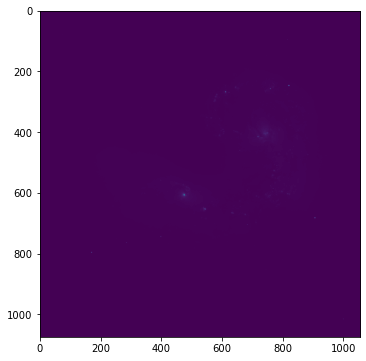

In [50]:
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(image)

That may not have looked like much, but it did at least confirm we have a 2D image. Let's tweak some settings. 

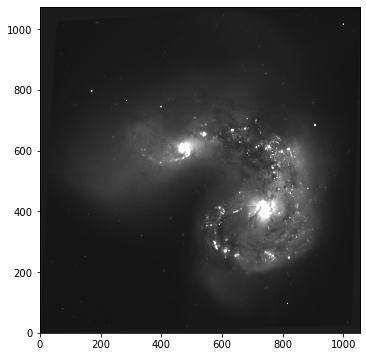

In [58]:
import numpy as np
fig, ax = plt.subplots(figsize=(6,6))
m = np.mean(image)
s = np.std(image)
ax.imshow(image,origin='lower',vmin=m-s,vmax=m+5*s,cmap='gray');

Next, we need to plot with our $x$ and $y$ axes representing sky coordinate (RA/DEC) rather than pixel position. For this, we'll need to use `astropy`'s `World Coordinate System` module. There are several defined coordinate systems on the sky, but for this class, we'll primarily be using RA and DEC. (i.e., equitorial coordinates measured in hour angles and degrees). 

In [59]:
from astropy.wcs import WCS 

wcs_im = WCS(header)

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]


The wcs for a given image is constructed from the image header, where some information about the pixel scale and image pointing are stored. Notice here we got a warning. This happens sometimes with *HST* images that are mosaics of pointings that have already been drizzled (an image alignment/combination process). We need to remove the mentioned coefficients.

The following will be provided for lab:

In [60]:
def strip_SIP(header):
    A_prefixes = [i for i in header.keys() if i.startswith('A_')]
    B_prefixes = [i for i in header.keys() if i.startswith('B_')]
    for a,b in zip(A_prefixes,B_prefixes):
        del header[a]
        del header[b]
    return header

In [61]:
header_fixed = strip_SIP(header)
wcs = WCS(header_fixed)

We are now ready to plot our image in celestial coordinates. Our game plan is to use `matplotlib`'s `projection`. You may be familiar with this as the way to make an axis, e.g., in polar coordinates. `Astropy` `WCS` objects can be treated as projections in `matplotlib`. Below I show two ways to initialize an axis with our new wcs projection.

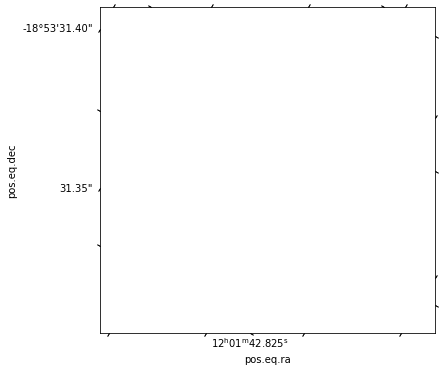

In [62]:
fig, ax = plt.subplots(figsize=(6,6),subplot_kw={'projection':wcs})

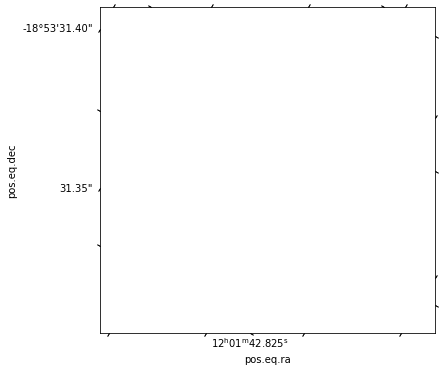

In [63]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection=wcs)

The two methods work equally well. The former is slightly preferred, as it makes it easy to make multiple panels with a wcs projection. 

Now, all we have to do, is plop our image into it:

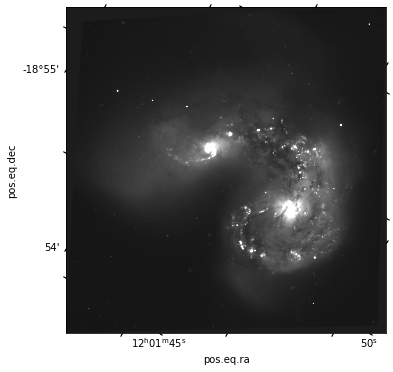

In [64]:
fig, ax = plt.subplots(figsize=(6,6),subplot_kw={'projection':wcs})
ax.imshow(image,origin='lower',vmin=m-s,vmax=m+5*s,cmap='gray');

In [65]:
ax

<WCSAxesSubplot:xlabel='pos.eq.ra', ylabel='pos.eq.dec'>

### Lab Preview 

In this lab, you'll be working with the same image of the Antenna galaxy, in several bands. In addition to the basic reading in and use of header/wcs, you'll be learning about `SkyCoord`, the `astropy` handler for coordinates, and `units` which is a module we'll be discussing throughout class. You'll use `Cutout2D` to make zoom in plots of the image while retaining coordinate information. And you'll use the `photutils` package and `sep` to find sources and perform some aperture photometry. 


# Lab: Astronomical Images

Astronomical images are one of the basic building blocks of astronomical research. While we now obtain data in myriad ways, from gravitational waves to neutrinos, from spectra to polarimetry, the basic tenant of astronomy (and it's most recongizable public impact) is the images we make of the sky. 

That is why the first science topic we'll be tackling is imaging. And along the way, we'll learn how `astropy` makes our lives *so* much easier when dealing with images, and how to use robust functions to perform the analyses one might want to carry out on images (after we're done admiring their beauty). 

Many of you are probably familiar with the `FITS` standard. It stands for `Flexible Image Transport System`, and for all intents and purposes, it acts as a container (much like a zip file). Within it, one can store several kinds of information: images (2d arrays of values), as the name implies, headers (dictionary like objects with metadata), and sometimes tabular data as well. A `FITS` file can contain any number of *extensions*, which just refer to "slots" where stuff is stored. Every "slot" has a `header` attribute and a `data` attribute. Thus, you could store a hundred astronomical images in 1 file, each with a different extension and a different header describing the image in that slot.  

:::{tip}
Contextual clues are important when dealing with `FITS` files. Files that are explicitly single images almost always have the image stored in the 0th extension, while files that are explicitly table data tend to have the table stored in the 1st extension (with the 0th empty). 
:::

The `FITS` standard is pretty old, and may be retired soon, but almost all ground based telescopes still use it for their native image output, so it behooves us to know how to get image data out of `FITS` files. 

:::{admonition} Exercise 1: Loading a FITS File
Write a function which takes as its argument a `string` filepath to a `FITS` file, and should have an optional argument to set the extension (default 0). It should then load the given extension of that `fits` file using a [context manager](https://docs.astropy.org/en/stable/io/fits/index.html#opening-a-fits-file), and return a tuple containing the header and data of that extension. 

The function should have documentation that describes the inputs and outputs. 

Then **use your function** to read in the antennae R-band image.
:::



In [ ]:
# Your Code Here 

:::{admonition} Exercise 2.1: Plotting

Next, we need to plot the image data. There are several operations that we almost always perform when plotting astronomical data, as well as several user-preferences for how we "by default" plot images before we begin tweaking things. If you spend any time as an astronomer, you will plot quite literally *thousands* of images --- why set all these settings every time, when we can write a handy function to do it for us?

Write a function which takes in as input arguments 
- an image (2D array or masked array) 

as well as the following optional arguments (so set a default)
- figsize (default (15,13) )
- cmap (default 'gray_r')
- scale (default 0.5)
- \*\*kwargs (see [here](https://prappleizer.github.io/Tutorials/FunctionalProgramming/FunctionalProgramming_web.html))

Inside the function, create figure and axes objects using `plt.subplots()`. When working in notebooks, it is often useful to set the `figsize` argument of subplots to a nice large-ish value, such as `(15,13)`, which will make the image fill most of the notebook. Since *your* function has set figsize as an argument, you can feed `figsize` directly into the `subplots` call, so that a user of the function can leave the default or set their own. 

Next, use `ax.imshow()` to actually plot the image. You'll want to save the output of this, e.g., `im = ax.imshow(...)`. In this plotting call, set `imshow`'s argument `origin='lower'`. We *always* want to do this when dealing with imaging, as we want (0,0) to be a coordinate. 
```{note}
By default, matplotlib uses a "matrix-style" plotting, where 0 of the y axis is in the *top* left corner, and 0 of the x axis is in the *bottom* left corner.
```
Also within the call to `imshow()`, feed in the cmap from your function (i.e., `cmap=cmap`). The other critical `imshow()` arguments are `vmin` and `vmax`, which sets the saturation points (and thus the contrast) of the image. 

We haven't set `vmin` and `vmax` as arguments of our outer function, but because of `kwargs`, we can still create a default here that can be overriden from outside. 

As a default, within your function, calculate the mean and standard deviation of the image. Set some temporary variables with the quantities `mu - scale*sigma` and `mu + scale*sigma` (where here `mu` is the calculated mean and `sigma` is the calculated std dev, and `scale` was the optional input). Next, check the kwargs dictionary (which will exist in your function because we added the packing argument `**kwargs` to our function. IF `vmin` and `vmax` are in this dictionary, plug those into your imshow command. Otherwise, use the values determined by the calculation above. Bonus point for accomodating either no vmin/vmax entered, just vmin or vmax, or both (using the calculated values when things aren't provided). 

Your function should **return** the created `fig` and `ax` objects so the user can continue to tweak them.

Run your function and test its outputs. Once you're satisfied it's working, use it to plot the provided data. Find either a vmin/vmax pair, or a choice of `scale` which makes the image look pretty!

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Your code
def implot(...):
    ''' 
    WRITE DOCSTRING HERE
    '''
    pass #replace with your code

:::{admonition} Exercise 2.2 More: Features

Copy your function down, we're going to keep messing with it. 

So far, we've made it so that with a simple function call and, potentially, with just the input of an image array, we get out a nice plot with a scaling, colormap, and origin selection. In this section, we are going to allow (optionally) for a colorbar to be added to the figure. We're also going to add in the ability for the figure to be plotted in celestial coordinates (i.e., RA and DEC) instead of pixel units, if information about the image (via the world coordinate system, WCS) exists in the image header. 

:::{note}
Generally, WCS information is present in the headers of *published* images like the one here, but *not* present in raw data gathered at the telescope. This is because images need to undergo a process known as *plate solving* to determine both the direction (coordinates) toward the image, as well as the pixel scale (i.e., how many arcseconds per pixel in the image). 
:::

Add three new optional arguments to your function.
- colorbar = False
- header = None
- wcs = None

Let's start with the colorbar. At the end of your plotting commands, check if `colorbar=True`, and if so, create a colorbar via `plt.colorbar()`, setting the `mappable` argument to whatever you saved the output of `ax.imshow()` into above. Also set the `ax` argument to be your ax; this will tell `matplotlib` to steal a bit of space from that axis to make room for the colorbar. 
:::


In [2]:
# Your code here

:::{tip}
When I do this, the colorbar is matching the figure height, rather than the axis height. If that bugs you like it bugs me, jump to the bottom of this workbook for a slightly more complicated, but robust, way of making the colorbar exactly the height (or width) of the axis.
:::



In order to plot in RA and DEC coordinates, we need to first have an `astropy` `WCS` object associated with the image in question. You can import `WCS` from `astropy.wcs`. WCS objects are created from the headers of plate-solved fits files. In our function, we allow the user to input either a header or a WCS object directly. More on WCS can be found in the lecture notes, or [here](https://docs.astropy.org/en/stable/wcs/index.html).

:::{admonition} Exercise 2.3: Adding WCS Plotting

Within your function, check if a wcs is input -- if it is, we're good to go and can safely ignore `header` (even if it is provided). If instead only `header` is provided, use the `WCS()` function to create a new wcs object from that header. 
```{tip}
You'll want to do this at the very top of your function.
```

We now need to move our `fig, ax = ....` creation line into an if-statement. If we are using WCS "stuff", you'll need to set a `projection` for your plot that uses the wcs. This is accomplished as follows:

```
fig, ax = plt.subplots(...,subplot_kw={'projection':wcs}) 
```
where `wcs` is whatever you've named the output of `WCS(header)` or is the WCS input directly into the function. 
:::


In [ ]:
from astropy.wcs import WCS

# your code

:::{warning}
In this case, we will get an error from our function that happens because of some distortion coefficient nonsense between astropy and drizzled HST images. Since it's not pertinent to our lab, I'm providing below a snippet of code you should use to fix your header before running `WCS(header)`. 
:::

In [3]:
def strip_SIP(header):
    A_prefixes = [i for i in header.keys() if i.startswith('A_')]
    B_prefixes = [i for i in header.keys() if i.startswith('B_')]
    for a,b in zip(A_prefixes,B_prefixes):
        del header[a]
        del header[b]
    return header

If this worked correctly, when you add the header you read in from our image, you should now see the axes of your plot change from pixels to `pos.eq.ra` and `pos.eq.dec`. We're now looking at actual on-sky coordinates! Yay!

:::{admonition} Exercise 2.4: Plotting Goodies
Within the if-blocks of your function that sets the `ax` to be a wcs projection, set the $x$ and $y$ labels to read "Right Ascension \[hms\]" and "Declination \[degrees\]" in fontsize 15.

Lastly, to polish things off, use `ax.tick_params()` to set inward, larger ticks, and increase the axis tick label size to 15. 

```{note}
You'll notice (especially with larger ticks) that the are not perpendicular to the axes spines. This is because this particular image has been rotated with respect to the standard celestial coordinate axes. This can be seen more clearly if you add the following to your function:
`ax.coords.grid(color='gray', alpha=0.5, linestyle='solid')`. Try doing that, adding an optional keyword to your function called 'grid' and enabling this command if it is set.
```

```{tip}
To check if a condition is true (e.g, `if condition == True:`), you can just type `if condition:`
```

It's taken us some time, but this image could now be placed in a scientific publication. And, since we have a handy function for it, we can make images that look this nice on the fly with a short one line command, yet still have a lot of flexibility over many important inputs. And of course, the figure and axes objects are returned, so one could run this function and then continue tweaking the plot after the fact.

```{note}
As a final note, I want to draw your attention to the fact that once you use the `wcs` projection on some plot, it's no longer a normal ax object, it's a wcsax object. This makes changing certain elements of those axes a little more involved than for a standard one. I use [this page](https://docs.astropy.org/en/stable/visualization/wcsaxes/ticks_labels_grid.html) and the others linked there when doing so. 
```

## Cutouts

When working with astronomical images, like the one we've been using in this lab, it is often advantageous to be working with a cutout -- a chunk of the image centered on a certain coordinate, and of a certain size. For example, if there is an HII region or star cluster of interest in the above image, we may like to zoom in on it to examine it more closely. 

Now that we've switched over to using celestial coordinates instead of pixels as our projection frame, zooming in on a region is not as simple as slicing our array, e.g., `image[500:700,200:550]`. On the plus side, the framework we'll learn here is very robust, and will allow for all sorts of useful measurements. 

To make a cutout, we'll need the `Cutout2D` module within `astropy`, which I'll import below. To provide the position of the cutout, we need to be able to feed in astronomical coordinates. For this, we'll use `SkyCoord`, a module in `astropy.coordinates`. Finally, we'll need to integrate the `units` module in `astropy` to successfully create coordinate objects.



In [4]:
from astropy.nddata import Cutout2D
from astropy.coordinates import SkyCoord
import astropy.units as u

Let's start with a `SkyCoord` object. There are several coordinate systems used in astronomy, e.g., Galactic coordinates ($b$, $l$), Equatorial ($RA$, $DEC$). The most common (especially in any extragalactic setting) is RA and DEC (as you can see in the image you've plotted already). 

The [documentation](https://docs.astropy.org/en/stable/api/astropy.coordinates.SkyCoord.html) for `SkyCoord` is solid, and worth reading. 

The general way we create these objects is, e.g.,Let's start with a `SkyCoord` object. There are several coordinate systems used in astronomy, e.g., Galactic coordinates ($b$, $l$), Equatorial ($RA$, $DEC$). The most common (especially in any extragalactic setting) is RA and DEC (as you can see in the image you've plotted already). 

The [documentation](https://docs.astropy.org/en/stable/api/astropy.coordinates.SkyCoord.html) for `SkyCoord` is solid, and worth reading. 

The general way we create these objects is, e.g.,

In [5]:
coord = SkyCoord('12:01:53.6 -18:53:11',unit=(u.hourangle,u.deg))

:::{tip}
You can input various types of strings and formattings for the coordinates, just be sure to specify the units as shown above. The documentation shows the various methods. You can also enter RA and DEC separately if you have them stored that way, e.g., `SkyCoord(ra=241.53,dec=7.1345,unit='deg')`.
:::

:::{admonition} Exercise 3.1: Make a Cutout

In this case, the coordinates I set above are for NGC 4039, which is the smaller of the two galaxies in the image we're using. 

```{note}
If at any point you're trying to make a coordinate object for a well known galaxy/object, try, e.g., `coord = SkyCoord.from_name('NGC 4038')`, and ususally that will work!
```


In the cell below, use the coordinate we've created, plus a size (use 1x1 arcminutes), and the wcs object for our image, to create a `Cutout2D` object. 
:::

In [6]:
# your code here

Now, use your fancy new function to plot the new cutout. 
:::{hint}
Cutout objects contain the image and their own wcs as attributes, accessible via, e.g., `cutout.data` and `cutout.wcs`. 
:::


Congrats! You're now able to interact with images using `astropy`. Some next steps may be running sep/source extracter to find objects, or perform aperture photometry on regions of the image.

If those are things you might actually do this summer, check out the second half of [this lab](https://astro-330.github.io/Lab2/Lab2.html) to continue along this path.
